# Поиск по изображениям

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.  

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:
⎢ A man is crossing a mountain pass on a metal bridge.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import re
import os
from os import listdir
from os.path import isfile, join
import nltk
import winsound
from tqdm import tqdm
from PIL import Image
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50

In [27]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\evgeniy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evgeniy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\evgeniy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Исследовательский анализ

Загрузим все данные, что у нас есть

In [28]:
crowd_annot = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/CrowdAnnotations.tsv', sep='\t', header=None)
expert_annot = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/ExpertAnnotations.tsv', sep='\t', header=None)
train_data = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/train_dataset.csv')
test_queries = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_queries.csv', sep='|', usecols=[1, 2, 3])
test_images = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images.csv')

all_docs = {'crowd_annot': crowd_annot,
            'expert_annot': expert_annot,
            'train_data': train_data,
            'test_queries': test_queries,
            'test_images': test_images}

Посмотрим на содержание

In [29]:
for doc in all_docs:
    print(doc)
    print(all_docs[doc].head(2))
    print(all_docs[doc].info())
    print('-----------------------------------------------------------------------------')

crowd_annot
                           0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None
-----------------------------------------------------------------------------
expert_annot
                           0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 

Переименуем столбцы в crowd_annot и expert_annot, чтобы они несли смысл.

In [30]:
crowd_annot = crowd_annot.rename(columns={0: "image", 1: 'query_id', 2: 'aprove_share', 3: 'aprove_num', 4: 'reject_num'})
expert_annot = expert_annot.rename(columns={0: "image", 1: 'query_id', 2: '1_exp', 3: '2_exp', 4: '3_exp'})

Соединим оценки экспертов и комьюнити

In [31]:
crowd_and_expert = crowd_annot.merge(expert_annot, on=['image', 'query_id'], how='left')
crowd_and_expert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47830 entries, 0 to 47829
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   aprove_share  47830 non-null  float64
 3   aprove_num    47830 non-null  int64  
 4   reject_num    47830 non-null  int64  
 5   1_exp         2329 non-null   float64
 6   2_exp         2329 non-null   float64
 7   3_exp         2329 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 3.3+ MB


Я соединял по двум столбацм: имя изображения и описание, и получились, тчо только в 2329 случаях значения в этих столбцах совпали. Теперь нам надо понять, а где же лишние описания и изображения.
Соеденим теперь поочередно эти таблицы с таблицей train_data.

In [32]:
expert_and_train = expert_annot.merge(train_data, on=['image', 'query_id'], how='left')
expert_and_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   1_exp       5822 non-null   int64 
 3   2_exp       5822 non-null   int64 
 4   3_exp       5822 non-null   int64 
 5   query_text  5822 non-null   object
dtypes: int64(3), object(3)
memory usage: 318.4+ KB


In [33]:
crowd_and_train = crowd_annot.merge(train_data, on=['image', 'query_id'], how='left')
crowd_and_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47830 entries, 0 to 47829
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   aprove_share  47830 non-null  float64
 3   aprove_num    47830 non-null  int64  
 4   reject_num    47830 non-null  int64  
 5   query_text    2329 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.6+ MB


Оценки экспертов 1:1 соединились с `train_data`, а вот оценки комьюнити совпали с `train_data` все в тех же 2329 строках.
Еще посмотрим, что будет. если соединить оценки комьюнити с `train_data` только по полю `image`

In [34]:
half_crowd_and_train = crowd_annot.merge(train_data, on=['image'], how='left')
half_crowd_and_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277460 entries, 0 to 277459
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   image         277460 non-null  object 
 1   query_id_x    277460 non-null  object 
 2   aprove_share  277460 non-null  float64
 3   aprove_num    277460 non-null  int64  
 4   reject_num    277460 non-null  int64  
 5   query_id_y    277460 non-null  object 
 6   query_text    277460 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 16.9+ MB


Т.е. можно сделать вывод, что картинки в `crowd_annot` и `train_data` исмользуются одни и те же. Ещё посмотрим, а сколько всего уникальных изображений.

In [35]:
print('уникальных изображений в train_data: ', len(train_data['image'].unique()))
print('уникальных изображений в expert_annot: ', len(expert_annot['image'].unique()))
print('уникальных изображений в crowd_annot: ', len(crowd_annot['image'].unique()))

уникальных изображений в train_data:  1000
уникальных изображений в expert_annot:  1000
уникальных изображений в crowd_annot:  1000


Итого мы имеем, что во всех 3 фалах одинаковое количество изображений. Пары изображения+описание одинаковые в `expert_annot` `tarin_data`, но в файле `crowd_annot` есть не все пары из `tarin_data`, а так же множество своих уникальных пар. Вопрос: нужны ли нам эти дополнительные описания из `crowd_annot`? Наверное нет, потому что у нас есть только query_id этих описаний и нет самих текстов.

Я соединяю 3 файла, так чтобы у нас были и тексты и оценки из всех источников.

In [36]:
train_data_annot = train_data.merge(crowd_annot, on=['image', 'query_id'], how='left').merge(expert_annot, on=['image', 'query_id'], how='left')
print(train_data_annot.info())
train_data_annot.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   query_text    5822 non-null   object 
 3   aprove_share  2329 non-null   float64
 4   aprove_num    2329 non-null   float64
 5   reject_num    2329 non-null   float64
 6   1_exp         5822 non-null   int64  
 7   2_exp         5822 non-null   int64  
 8   3_exp         5822 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB
None


,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.0,3.0,1,1,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,NaN,NaN,1,1,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,0.0,3.0,1,2,2
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,3.0,0.0,4,4,4
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,NaN,NaN,NaN,1,1,1


Теперь нам нужна одна единая оценка. Предлагается следующая модель:
1. Будем переводить оценку в шкалу от 0 до 1
2. Оценки экспертов будут приобразованы по принципу: 1 = 0; 2 = 0.3; 3 = 0,6 и 4 = 0,9. 
3. Оценки комьюнити уже и так в шкале от 0 до 1
4. Будем считать, что голос эксперта в 2 раза весомее голоса члена комьюнити.
5. Общая формула соотвестсивия описания такая: (оценка комьюнити) * (число оценщиков в комьюнити/(число оценщиков в комьюнити + 6)) + (средняя оценка экспертов) * (6/(6+число оценщиков в комьюнити))

Для начала заменил NaN на 0, при такой замене наша средняя взвешенная оценка не должна пострадать

In [37]:
train_data_annot = train_data_annot.fillna(value=0)

Затем заменим оценки экспертов согласну пункту 2 плана описанного выше

In [38]:
train_data_annot = train_data_annot.replace({
    '1_exp': {1: 0, 2: 0.3, 3: 0.6, 4: 0.9},
    '2_exp': {1: 0, 2: 0.3, 3: 0.6, 4: 0.9},
    '3_exp': {1: 0, 2: 0.3, 3: 0.6, 4: 0.9}})

In [39]:
train_data_annot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   query_text    5822 non-null   object 
 3   aprove_share  5822 non-null   float64
 4   aprove_num    5822 non-null   float64
 5   reject_num    5822 non-null   float64
 6   1_exp         5822 non-null   float64
 7   2_exp         5822 non-null   float64
 8   3_exp         5822 non-null   float64
dtypes: float64(6), object(3)
memory usage: 454.8+ KB


In [40]:
def weighted_average(row):
    w_a = (row['aprove_share']*((row['aprove_num']+row['reject_num'])/(row['aprove_num']+row['reject_num']+6))
     + statistics.mean([row['1_exp'], row['1_exp'], row['1_exp']])*(6/(row['aprove_num']+row['reject_num']+6)))
    return w_a

In [41]:
train_data_annot['w_a'] = train_data_annot.apply(weighted_average, axis=1)

Теперь у нас есть средневзвешанные оценки по соответсвию изображений и описаний всех 5822 строк из `train_data`

In [42]:
train_data_annot.sample(10)

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a
803,3218480482_66af7587c8.jpg,3218480482_66af7587c8.jpg#2,A Miami basketball player dribbles by an Arizo...,1.0,3.0,0.0,0.9,0.9,0.9,0.933333
5752,494921598_af73bda568.jpg,3439382048_d2e23b2b4c.jpg#2,A man reaches toward dunking a basketball whil...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2843,757046028_ff5999f91b.jpg,3589367895_5d3729e3ea.jpg#2,An Indian chief in full dress .,0.0,0.0,0.0,0.0,0.0,0.3,0.000000
3279,3364861247_d590fa170d.jpg,2497420371_74788d7ba1.jpg#2,A man in a black cap is opening a bag beside a...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2840,160792599_6a7ec52516.jpg,3589367895_5d3729e3ea.jpg#2,An Indian chief in full dress .,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3497,2061354254_faa5bd294b.jpg,535830521_aa971319fc.jpg#2,"A woman holds a newspaper that says "" Real cha...",0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5386,2764178773_d63b502812.jpg,1461667284_041c8a2475.jpg#2,A man in a white hat plays guitar on a stage .,0.0,0.0,0.0,0.0,0.3,0.3,0.000000
3442,2229179070_dc8ea8582e.jpg,3044536048_e615466e7f.jpg#2,A person in a green jacket it surfing while ho...,0.0,0.0,0.0,0.0,0.3,0.3,0.000000
2911,2890113532_ab2003d74e.jpg,327415627_6313d32a64.jpg#2,Two dogs run through a field .,1.0,3.0,0.0,0.9,0.9,0.9,0.933333
3632,3503689049_63212220be.jpg,1287073593_f3d2a62455.jpg#2,Dogs pulling a sled in a sled race .,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Под конец анализа удостоверимся, что изображения в 2 тестовых таблицах соотвествуют друг другу.

In [43]:
test_dfs = test_queries.merge(test_images, on='image', how='inner')
test_dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Да, убедились, что все ок.

## Подготовка данных

Нам необходимо исключить из тренировочнызх данных описания, которые могут попадать под юридические ограничения. Создадим список слов.

In [44]:
baned_words = ['kid ', ' kid' 'little boy', 'little girl', 'young boy', 'young girl', 'child ', ' child', ' teenager', 'teenager ', 'baby ', ' baby', 'boy']

Напишем функцию, которая добавит признак, если в тексте описания есть запрещенные слова

In [45]:
def func_baned_words(row):
    count = 0
    for word in baned_words:
        text = row['query_text'].lower()
        if word in text:
            count += 1
    if count > 0:
        return 1
    else:
        return 0


In [46]:
train_data_annot['baned'] = train_data_annot.apply(func_baned_words, axis=1)

In [47]:
train_data_annot[train_data_annot['baned']==1]

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a,baned
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,0.0,0.0,0.0,0.000000,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,3.0,0.0,0.3,0.3,0.000000,1
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,3.0,0.0,0.9,0.9,0.9,0.933333,1
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
5797,391579205_c8373b5411.jpg,909191414_1cf5d85821.jpg#2,A young boy jumping in front of a young girl a...,0.000000,0.0,3.0,0.0,0.0,0.6,0.000000,1
5803,444481722_690d0cadcf.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...,0.000000,0.0,3.0,0.0,0.0,0.0,0.000000,1
5804,488408004_a1e26d4886.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
5814,751109943_2a7f8e117f.jpg,2475162978_2c51048dca.jpg#2,a woman holding a small ball chasing after a s...,0.000000,0.0,0.0,0.0,0.0,0.3,0.000000,1


Получилось 791 строка с описаниями содержащими заперщенные слова, по заданию нужно их удалить.

In [48]:
train_data_annot_cleared = train_data_annot[train_data_annot['baned']==0]

### Векторизация текста

Проведём предобработку текстов: уберём все ненужные символы (лишние пробелы, цифры и т.д.), приведём к нижнему регистру, добавим pos-теги, лемматизируем/

In [49]:
lemmatizer = WordNetLemmatizer()

def clear_text(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)
    
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Remove digits
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Converting to Lowercase
    text = text.lower()
    
    return text

# function for pos tags
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def lemmatize(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [50]:
lem_corpus = []
X = train_data_annot_cleared['query_text']

for comment in tqdm(X):
    comment = clear_text(comment)
    comment = lemmatize(comment)
    lem_corpus.append(comment)

100%|████████████████████████████████████████████████████████████████████████████| 4582/4582 [00:04<00:00, 1086.31it/s]


Посмотрим на несколько получившихся описаний

In [51]:
print(random.choices(lem_corpus, k=5))


['a woman wear white glove peer over the crowd', 'a woman cross the street near man who be on his cellphone', 'a baseman try to catch ball while runner try to make the base in community game', 'a man wear green shirt look down at cellphone', 'a tennis player be carry tennis racket']


Вставим их в датафрейм на место исходных описаний

In [52]:
train_data_annot_cleared = train_data_annot_cleared.reset_index(drop=True)
train_data_annot_cleared.loc[:, 'query_text'] = lem_corpus

In [53]:
train_data_annot_cleared

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a,baned
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,3.0,0.0,0.0,0.3,0.000000,0
1,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,3.0,0.3,0.3,0.6,0.200000,0
2,2616643090_4f2d2d1a44.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,2648165716_02e2e74fd6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,1.0,3.0,0.0,0.9,0.9,0.9,0.933333,0
...,...,...,...,...,...,...,...,...,...,...,...
4577,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,a small animal leap behind large animal the la...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4578,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walk down the uncrowded road,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4579,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,a dog stand on the side of grassy cliff,0.0,0.0,0.0,0.3,0.3,0.3,0.300000,0
4580,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,a blurry photo of two dog,0.0,0.0,3.0,0.3,0.6,0.6,0.200000,0


Посмотрим на самое длинное предложение

In [54]:
print (max(train_data_annot_cleared['query_text'], key=len))
print(len(max(train_data_annot_cleared['query_text'], key=len).split()))


a man wear black boxing short and white boxing glove and man in white boxing short and white boxing glove be fight in the ring
25


Для преобразования текстов в вектор я буду использовать предтренированную модель `GloVe` взятую отсюда https://nlp.stanford.edu/projects/glove/  натренированную на словаре из 400K слов и где каждое слово представлено в 50-мерным вектором.

Идея в следующем: в файле `C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/Glove.6B.50d.txt` каждое слово уже представленно в виде 50 мерного вектора. Я буду находить среднее значение векторов слов входящих в каждое описание и таким образом постараюсь уловить общий смысл предложения. 

Самым лучшим способом было бы не находить среднее, а соеденить все вектора слов в каждом предложении. Но самое длинное предложение у нас состоит из 25 слов, что привело бы к работе с 1250 мерным пространством, к которому потом еще добавится n-мерность вектора изображения, что бы очень замедлило вычисления

Для начала закодируем самые популярные 5000 слов появляющееся в наших описаниях при помощи `Tokenizer`, это поможет нам в будущем сэкономить ресурсы.

In [55]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(lem_corpus)

Посмотрим на длину

In [56]:
len(tokenizer.word_index)

1078

Получилось всего 1156 слов. Теперь вместо токена каждому слову в этом словаре присвоим вектор из `GloVe`

In [57]:
def create_embedding(filepath, word_index):
    new_dict = {}

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                new_dict[word] = np.array(vector, dtype=np.float32)

    return new_dict

In [58]:
glove_embedding = create_embedding(
    'C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/Glove.6B.50d.txt',
    tokenizer.word_index,
)

Проверим длину получившегося нового словаря

In [59]:
len(glove_embedding)

1063

16 слов не удалось представить в виде ввектора, потому что их изначально не было в файле. Будет заменять их нулевыми веторами. Посмотрим на пример в качестве слова `girl`

In [60]:
glove_embedding['girl']

array([-0.34471 ,  0.69563 , -0.78086 , -0.58482 ,  1.2263  ,  1.2544  ,
       -0.76466 ,  0.40575 ,  0.18862 ,  0.098834,  0.32557 , -0.31816 ,
        0.23869 ,  0.33554 ,  1.0592  , -0.25266 , -1.0308  ,  0.70027 ,
        0.030457,  0.53866 , -0.30279 ,  1.7515  ,  0.3128  ,  1.2103  ,
        0.41335 , -1.9421  , -0.93756 ,  0.32453 ,  0.52249 , -0.86708 ,
        2.1258  , -0.20377 , -0.19061 ,  0.37736 ,  0.66205 ,  0.50211 ,
       -0.12544 , -0.83069 ,  0.21155 , -1.3091  , -0.44973 , -0.11648 ,
        0.033598, -0.68382 ,  0.99419 , -0.88262 ,  0.56601 , -1.327   ,
        0.37319 ,  0.022389], dtype=float32)

И посмотрим, какие слова не получилось преобразовать в вектор

In [61]:
removed = set(tokenizer.word_index.keys()) - set(glove_embedding.keys()) 
removed

{'backset',
 'carying',
 'conoes',
 'ganilla',
 'hulahoop',
 'motorbiker',
 'ollies',
 'retrives',
 'rollerblader',
 'somthing',
 'spash',
 'towarn',
 'wakeboarder',
 'wearfing',
 'windsurfs'}

Теперь напишем функцию, коорая будет возвращать среднее значение векторов всех слов участвующих в предложении

In [62]:
def setnence_to_vector(row):
    sentence_vectors = []
    query_word_list = row['query_text'].split()
    for word in query_word_list:
        if word in glove_embedding:
            sentence_vectors.append(glove_embedding[word])
        else:
            sentence_vectors.append(np.zeros(50))
    average_embedding_vector = np.mean(sentence_vectors, axis = 0)
    

    return average_embedding_vector

Применим функцию записав результат в новый столбец

In [63]:
train_data_annot_cleared['vector_query'] = train_data_annot_cleared.apply(setnence_to_vector, axis=1)

In [64]:
train_data_annot_cleared.sample(5)

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a,baned,vector_query
1996,3485425825_c2f3446e73.jpg,3128164023_ebe8da4c32.jpg#2,two dog identical white with brown spot wrestl...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"[-0.028312989, 0.24194919, -0.05855583, 0.0309..."
1722,307327914_f98f576adb.jpg,3584930205_a3f58a4b7c.jpg#2,a skateboarder ollies off ramp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"[-0.024825987219810487, 0.07818399667739868, 0..."
3916,3157847991_463e006a28.jpg,2306674172_dc07c7f847.jpg#2,a skateboarder jump his board down flight of s...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,"[0.06392556, 0.16551, 0.14179522, -0.15593177,..."
4124,2706766641_a9df81969d.jpg,3655074079_7df3812bc5.jpg#2,a naked woman wear body paint rid bicycle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"[-0.11448376, 0.118222125, -0.19909099, -0.498..."
988,2913965136_2d00136697.jpg,3359551687_68f2f0212a.jpg#2,a woman be do backwards flip in front of crowd...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"[0.23244876, 0.096302345, -0.025569702, -0.254..."


### Векторизация изображений

Сделаем модель на основе `ResNet50` c весами тренированными на `imagenet`, добавив к ней один слой с 50 нейронами. Веса поставим необучаемыми

In [65]:
resnet_model = Sequential()

model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')

resnet_model.add(model)
resnet_model.add(Dense(50, activation='relu'))
resnet_model.add(Flatten())

for layer in resnet_model.layers:
    layer.trainable=False

In [66]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 50)                102450    
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
Total params: 23,690,162
Trainable params: 0
Non-trainable params: 23,690,162
_________________________________________________________________


Сделаем датагенератор

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data_annot_cleared,
        directory='C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/train_images/',
        x_col='image',
        y_col='baned',
        target_size=(224, 224),
        batch_size=1,
        class_mode='raw',
        seed=12345) 

Found 4582 validated image filenames.


Прогоним изображения через нашу сеть

In [68]:
features_example = resnet_model.predict(train_gen_flow, 1)

4582/4582 [==============================] - 407s 89ms/step


По неизвестной для меня причине (я создал вопрос на stackoverflow) прогоняя одни и теже изображения (они ведь повторяются в train_data_annot_cleared) получаюьтся все равно разные векторы. Я покажу это ниже

In [69]:
train_data_annot_cleared.loc[[0,10]]

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a,baned,vector_query
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,3.0,0.0,0.0,0.3,0.0,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272..."
10,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,a man sleep under blanket on city street,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0,"[0.14129551, 0.20963964, -0.2139675, -0.308213..."


Как видим, в 0 и 10 строке у нас одно и то же название файла с картинкой. Но вот 0 и 10 вектор не одинаковы

In [70]:
features_example[0] == features_example[10]

array([False,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True])

Поэтому я написал свою функцию

In [71]:
def func_image_to_vec(row):
    img = image.load_img(path+str(row['image']), target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    img_features = resnet_model.predict(x, 1)[0]

    return img_features

In [72]:
path = 'C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/train_images/'
features_list = train_data_annot_cleared.apply(func_image_to_vec, axis=1)

1/1 [==============================] - 0s 102ms/step


Теперрь проверим, одинаковые ли 0 и 10 векторы

In [73]:
features_list[0] == features_list[10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Сохраним преобразованные изображения в наш датафрейм

In [74]:
train_data_annot_cleared['vector_image'] = features_list
train_data_annot_cleared.head()

,image,query_id,query_text,aprove_share,aprove_num,reject_num,1_exp,2_exp,3_exp,w_a,baned,vector_query,vector_image
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,3.0,0.0,0.0,0.3,0.000000,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272...","[0.0, 0.0, 0.0, 2.0150523, 0.95354176, 9.48938..."
1,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,3.0,0.3,0.3,0.6,0.200000,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272...","[0.0, 0.0, 0.0, 0.0, 2.5413775, 0.0, 0.0, 4.73..."
2,2616643090_4f2d2d1a44.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272...","[0.0, 0.0, 0.0, 4.0204325, 0.0, 0.0, 0.8910804..."
3,2648165716_02e2e74fd6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272...","[0.0, 5.8177934, 0.0, 0.0, 0.0, 1.0753556, 0.0..."
4,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,a girl wear yellow shirt and sunglass smile,1.0,3.0,0.0,0.9,0.9,0.9,0.933333,0,"[-0.31761125, 0.39235497, -0.5935412, -0.26272...","[0.0, 0.0, 0.0, 2.363248, 0.0, 0.0, 0.0, 14.56..."


### Подготовка данных для обучения модели

Для начала соеденим векторы изображений и описаний

In [75]:
train_data_annot_cleared['united_vector'] = train_data_annot_cleared.apply(lambda x: np.concatenate([x['vector_query'], x['vector_image']]),axis=1)

Теперь разделим выборку на обучающую и валидационную так, чтобы одни и теже изображения были либо, в обучении либо в валиде. 

In [76]:
train_idx, test_idx = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state =7).split(train_data_annot_cleared, groups=train_data_annot_cleared['image']))
train_df = train_data_annot_cleared.iloc[train_idx]
valid_df = train_data_annot_cleared.iloc[test_idx]

Проверим, что изображения разделились правильно

In [77]:
print(len(set(train_df['image'])))
print(len(set(valid_df['image'])))

800
200


Теперь определеим features и target

In [78]:
features_train, target_train = train_df['united_vector'], train_df['w_a']
features_valid, target_valid = valid_df['united_vector'], valid_df['w_a']

Преобразуем features_train и features_valid в np.array так, чтобы модель могла обучаться, а также проведём нормализацию

In [79]:
features_train = features_train.to_numpy()
features_train = np.array([x.reshape((100)) for x in features_train])
features_train = normalize(features_train)

features_valid = features_valid.to_numpy()
features_valid = np.array([x.reshape((100)) for x in features_valid])
features_valid = normalize(features_valid)

In [80]:
target_train = target_train.to_numpy()
target_train = np.array([x.reshape((1)) for x in target_train])
target_valid = target_valid.to_numpy()
target_valid = np.array([x.reshape((1)) for x in target_valid])

In [81]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(3669, 100)
(3669, 1)
(913, 100)
(913, 1)


## Выбор модели

### Линейная регрессия

In [82]:
lin_model = LinearRegression()

In [83]:
lin_model.fit(features_train, target_train)

LinearRegression()

In [84]:
y_pred_lin = lin_model.predict(features_valid)

In [85]:
mse_lin = mean_squared_error(target_valid, y_pred_lin, squared=False)

In [86]:
mse_lin

0.22741210570972326

Результат неплохой и легко интерпретируемый. Взмешенная оценка отклоняется примерно на 0.23 

### Нейронная сеть

Для начала построим нейронную сеть без перебора гипперпараметров

In [87]:
simple_n_model = Sequential()

simple_n_model.add(Dense(units=32, activation='relu', input_dim=features_train.shape[1]))
simple_n_model.add(Dense(units=60, activation='tanh'))
simple_n_model.add(Dense(units=1))

In [88]:
simple_n_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 60)                1980      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 5,273
Trainable params: 5,273
Non-trainable params: 0
_________________________________________________________________


In [89]:
optimizer = Adam(learning_rate=0.0001)
simple_n_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics='mean_squared_error')

In [90]:
early_stop = EarlyStopping(monitor='loss', patience=4)
hist = simple_n_model.fit(features_train, 
                          target_train, 
                          epochs=100, 
                          batch_size=32, 
                          callbacks=early_stop,
                          validation_data=(features_valid, target_valid))

Epoch 1/100
115/115 [==============================] - 1s 4ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 2/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 3/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0591 - val_mean_squared_error: 0.0591
Epoch 4/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0571 - val_mean_squared_error: 0.0571
Epoch 7/100
115/115 [=

Остановились на 139 эпохе, значит результаты не улучшались на протяжении 4 эпох. Проверим улучился ли результат по сравлению с линейной регрессией.

In [91]:
y_pred_nn = simple_n_model.predict(features_valid)

29/29 [==============================] - 0s 1ms/step


In [92]:
mse_nn = mean_squared_error(target_valid, y_pred_nn, squared=False)
mse_nn

0.23612177816381638

Базовая нейронная сеть справилась чуть хуже линейной регрессии. Отрисуем график

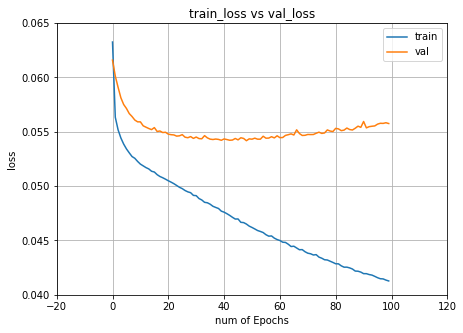

In [93]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_mse=hist.history['mean_squared_error']
val_mse=hist.history['val_mean_squared_error']
xc=range(100)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

Судя по графику где то после 20 эпохи пошло уже переобучение

Перебор параметоров

In [94]:
min(hist.history['val_loss'])

0.05417409539222717

In [95]:
hist.history['val_loss'].index(min(hist.history['val_loss']))

48

In [96]:
custom_n_model_list = []
number_of_layers = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
activ_func_list = ['relu', 'tanh']
units_list = [32, 64, 100, 10, 50, 40, 150, 12, 8, 4]
dropout_list = [0, 0.2, 0.4, 0.6]

for num in number_of_layers:
    layers_ex = []
    layers_ex.append(Dense(units=32, activation='relu', input_dim=features_train.shape[1]))
    for i in range(num):
        layers_ex.append(Dense(units=np.random.choice(units_list), activation=np.random.choice(activ_func_list)))
        layers_ex.append(Dropout(rate=np.random.choice(dropout_list)))
    layers_ex.append(Dense(units=1))
    custom_n_model = Sequential(layers_ex)
    custom_n_model_list.append(custom_n_model)
        

In [97]:
model_name_list = []
best_val_loss_list = []
best_epoch_list = []
for model in tqdm(custom_n_model_list):
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics='mean_squared_error')
    hist = model.fit(features_train,
                     target_train, 
                     epochs=100, 
                     batch_size=32, 
                     callbacks=early_stop,
                     validation_data=(features_valid, target_valid),
                     verbose=0)
    model_name_list.append(model.name)
    best_val_loss_list.append(min(hist.history['val_loss']))
    best_epoch_list.append(hist.history['val_loss'].index(min(hist.history['val_loss'])))
    
winsound.MessageBeep()

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:12<00:00, 11.02s/it]


In [99]:
result_df = pd.DataFrame({'model': model_name_list,
                          'best_val_loss': best_val_loss_list,
                          'best_epoch': best_epoch_list})
result_df.sort_values(by='best_val_loss')

,model,best_val_loss,best_epoch
1,sequential_3,0.053792,65
10,sequential_12,0.054065,12
0,sequential_2,0.054161,42
3,sequential_5,0.054387,31
11,sequential_13,0.054648,24
4,sequential_6,0.054656,15
9,sequential_11,0.054687,15
6,sequential_8,0.054848,14
5,sequential_7,0.054854,32
8,sequential_10,0.054885,24


Загрузим нашу лучшую модель

In [100]:
best_model = custom_n_model_list[1]

In [101]:
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                3232      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


натренируем ее заново с оптимальным количеством эпох

In [102]:
best_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics='mean_squared_error')

In [103]:
hist = best_model.fit(features_train,
                 target_train,
                 epochs=65, 
                 batch_size=32, 
                 callbacks=early_stop,
                 validation_data=(features_valid, target_valid),
                 verbose=2)

Epoch 1/65
115/115 - 1s - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - 691ms/epoch - 6ms/step
Epoch 2/65
115/115 - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - 202ms/epoch - 2ms/step
Epoch 3/65
115/115 - 0s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - 200ms/epoch - 2ms/step
Epoch 4/65
115/115 - 0s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - 318ms/epoch - 3ms/step
Epoch 5/65
115/115 - 0s - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - 191ms/epoch - 2ms/step


In [104]:
y_pred_bestnn = best_model.predict(features_valid)
mse_bestnn = mean_squared_error(target_valid, y_pred_bestnn, squared=False)

29/29 [==============================] - 0s 929us/step


In [105]:
print('Результат линейной регрессии:', mse_lin)
print('Результат лучгей нейронной сети:', mse_bestnn)

Результат линейной регрессии: 0.22741210570972326
Результат лучгей нейронной сети: 0.23186294386107859


Чуть лучше оказалась линейная регрессия, поэтому буду использовать ее

## Тестирование модели

Получим вектор изображений

In [178]:
onlyfiles = [f for f in listdir('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images/test_images') if isfile(join('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images/test_images', f))]
img_vectors = []
for name in onlyfiles:
    img = image.load_img('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images/test_images/'+name, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    img_features = resnet_model.predict(x, 1)[0]
    img_vectors.append(img_features)
img_vectors_ar = np.array(img_vectors)

1/1 [==============================] - 0s 91ms/step


Альтернативная загрузка векторов изображений

In [106]:
test_gen = ImageDataGenerator()
generator = test_gen.flow_from_directory(directory='C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images',
                                                   target_size=(224, 224),
                                                   batch_size=1,
                                                   class_mode=None,
                                                   shuffle=False)
features_img_test = resnet_model.predict(generator, 1)

Found 100 images belonging to 1 classes.


In [108]:
print(features_img_test.shape)
print(img_vectors_ar.shape)

(100, 50)

Загрузим описания

In [110]:
test_queries = pd.read_csv('C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_queries.csv', sep="|")

## Теперь напишем функцию, которая будет брать рандомное описание и предоставлять наиболее релевантную картинку.

In [189]:
def take_random_10():
    tets_df = pd.DataFrame(test_queries['query_text'].sample(10)).reset_index(drop=True)
    tets_df['baned'] = tets_df.apply(func_baned_words, axis=1)
    for i in range(len(tets_df['query_text'])):
        print('Поиск картинки по следющему описанию:', tets_df['query_text'][i], '...')
        if tets_df['baned'][i] == 1:
            print('Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос')
        else:
            lem_request = tets_df['query_text'][i]
            lem_request = clear_text(lem_request)
            lem_request = lemmatize(lem_request)
            sentence_vectors = []
            vector_request_word_list = lem_request.split()
            for word in vector_request_word_list:
                if word in glove_embedding:
                    sentence_vectors.append(glove_embedding[word])
                else:
                    sentence_vectors.append(np.zeros(50))
            average_embedding_vector = np.mean(sentence_vectors, axis = 0)
            combined_vectors = []
            picture_names = []
            for k in range(len(img_vectors_ar)):
                vector_combined = np.concatenate((average_embedding_vector, img_vectors_ar[k]))
                img_name = generator.filenames[k]
                combined_vectors.append(vector_combined)
                picture_names.append(img_name)
            features = np.array(combined_vectors)
            features = np.array([x.reshape((100)) for x in features])
            features = normalize(features)
            w_a_predicted = lin_model.predict(features)
            index = list(w_a_predicted).index(max(list(w_a_predicted)))
            w_a_chosen = max(list(w_a_predicted))
            print('Мы нашли картинку, которая подойдёт под ваше описание с вероятностью:', w_a_chosen)
            print(picture_names[index])
            img = Image.open("C:/Users/evgeniy/Desktop/practicum/Сборный проект 4/test_images/"+picture_names[index]).convert('RGB')
            plt.imshow(img)
            plt.show()

Поиск картинки по следющему описанию: A girl cross-country skis . ...
Мы нашли картинку, которая подойдёт под ваше описание с вероятностью: [0.28355928]
test_images\3154152744_4e93ec8a62.jpg


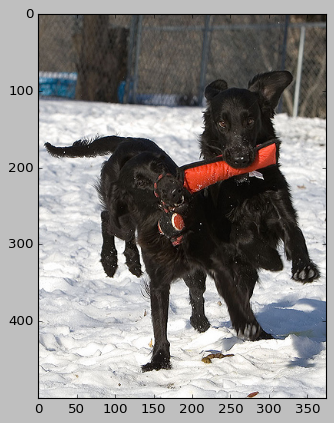

Поиск картинки по следющему описанию: A woman is throwing water on a child in a plastic swimming pool in a rural area . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A girl in a pool wearing goggles and surrounded by other children ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: Two boys are squirting water guns at each other . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A young boy jumps his bicycle on a tagged bike ramp . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A man hold

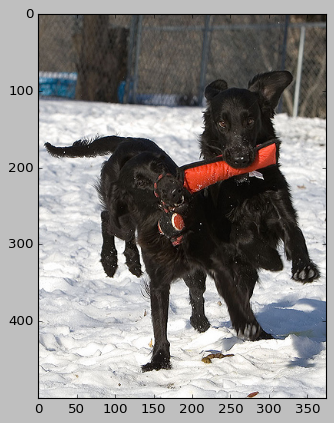

Поиск картинки по следющему описанию: A boy and a girl at the beach , throwing sand . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A little girl leans over the side of a wall to feed ducks in the water . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A young girl in blue hat and coat is riding a tricycle . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос
Поиск картинки по следющему описанию: A child sits in the woods looking up with binoculars . ...
Ваш запрос попадает под законодательные ограничения в связи с использованием изображения детей. Пожалуйста, попробуйте другой запрос


In [190]:
take_random_10()

## Вывод

К сожалению не получилось построить модель, которая бы давала релевантные картинки. Я пробывал по-разному загружать изображения, но все равно получается, что модель предстазывает одну и ту же картинку, хоть и с разными вероятностями. Т.е. она реально считает вероятности, просто эта картинка оказывается самой релевантной для абсолютно всех описаний. Буду очень рад понять, где я свернул не туда.